In [10]:
# %pip install -q tfds-nightly keras tensorflow
# %pip install -q seaborn
# %pip install -q tf2onnx
# %pip install -q onnxmltools
# %pip install --upgrade pip

In [11]:
import pandas as pd
import numpy as np
import matplotlib.dates as date
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import keras
import matplotlib.dates as date
import tensorflow as tf
from datetime import datetime
import seaborn as sns
import onnxmltools

<h1> Read, split, preprocces </h1>

In [12]:
# dataPATH = "lab_window3_RssiPerCrownPerTime.csv"
# dataPATH = "lab_window5_RssiPerCrownPerTime.csv"
# dataPATH = "lab_window10_RssiPerCrownPerTime.csv"
# dataPATH = "lab_window20_RssiPerCrownPerTime.csv"
# dataPATH = "lab_window30_RssiPerCrownPerTime.csv"
# dataPATH = "lab_window40_RssiPerCrownPerTime.csv"
# dataPATH = "lab_window50_RssiPerCrownPerTime.csv"
dataPATH = "lab_window60_RssiPerCrownPerTime.csv"

df = pd.read_csv(dataPATH, index_col=0)
print(df)

n_crownstones = 3
title = "60"

# manual enter feature columns
feature_names = [f"{i}.0" for i in range(n_crownstones)] + [f"mean{i}" for i in range(n_crownstones)] + [f"std{i}" for i in range(n_crownstones)]
# feature_names.append("")

features = df[feature_names].copy()

label = df[['posX', 'posY']].copy()  # labels x and y'

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=1, stratify=label)

# optional
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#

columnames = list(features.columns)+list(label.columns)
# sns.pairplot(df[columnames], diag_kind='kde')

                                   time        0.0        1.0        2.0  \
0      2023-07-05 17:28:05.057000+02:00 -74.952381 -70.181818 -73.090909   
1      2023-07-05 17:28:05.157000+02:00 -75.476190 -69.727273 -72.545455   
2      2023-07-05 17:28:05.257000+02:00 -74.727273 -69.454545 -71.909091   
3      2023-07-05 17:28:05.357000+02:00 -73.454545 -69.181818 -71.818182   
4      2023-07-05 17:28:05.457000+02:00 -72.181818 -68.909091 -71.727273   
...                                 ...        ...        ...        ...   
14933  2023-07-05 17:52:58.357000+02:00 -71.000000 -68.363636 -55.761905   
14934  2023-07-05 17:52:58.457000+02:00 -71.000000 -68.090909 -55.809524   
14935  2023-07-05 17:52:58.557000+02:00 -71.000000 -67.818182 -55.857143   
14936  2023-07-05 17:52:58.657000+02:00 -71.000000 -67.545455 -55.904762   
14937  2023-07-05 17:52:58.757000+02:00 -71.000000 -67.272727 -55.952381   

           mean0      std0      mean1      std1      mean2      std2  posX  \
0     -69

<h1> Layered Models Build </h1>

In [13]:
model = keras.Sequential([
    keras.layers.Dense(64, input_dim=9, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2)  # Output layer with 3 units for (x, y) later add , z)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')

<h1> Training </h1>

In [14]:
# Train the model
history = model.fit(X_train, y_train, validation_split = 0.2, epochs=1000, verbose = 0)

<h1> Evaluating model and Plotting </h1>

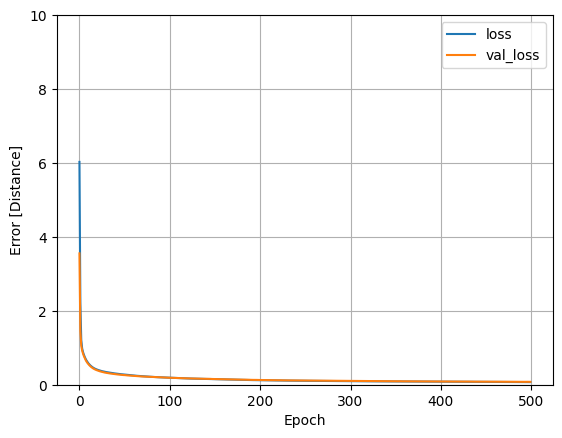

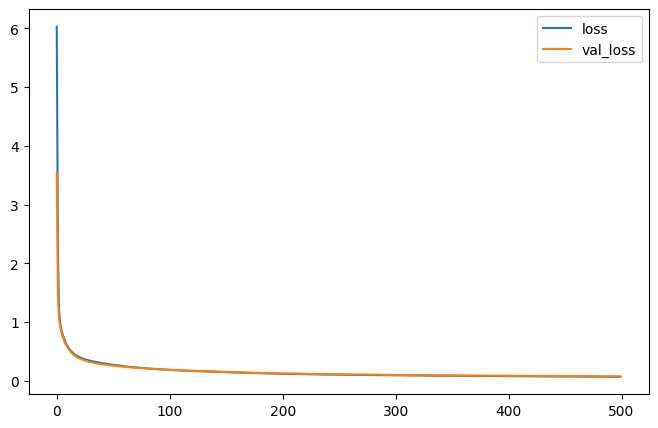

{'location_model': 0.08403827250003815}


In [15]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Distance]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

test_results = {}

test_results['location_model'] = model.evaluate(
    X_test,
    y_test, verbose=0)

print(test_results)

94/94 [==============================] - 0s 2ms/step


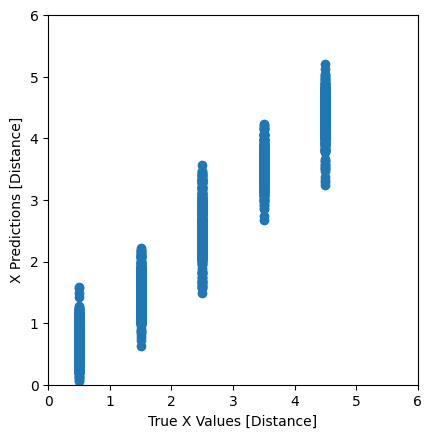

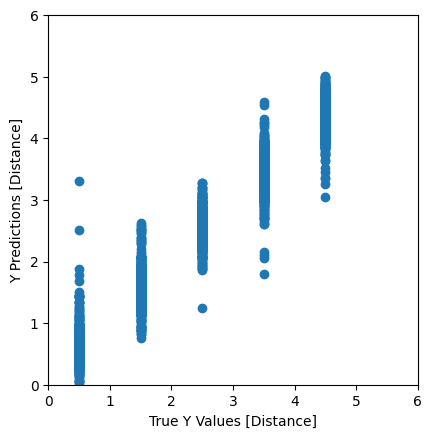

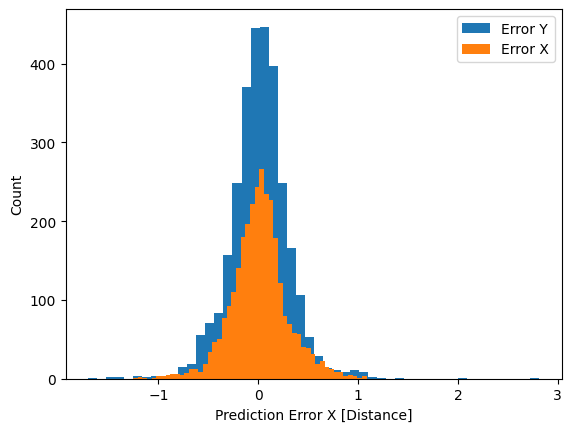

X Mean Absolute Error: 0.20907294552977704
X Mean Squared Error: 0.08019288944905412
X Root Mean Squared Error: 0.28318349077771837

Y Mean Absolute Error: 1.6232697279722377
Y Mean Squared Error: 3.930713635057037
Y Root Mean Squared Error: 1.9826027426232007

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                640       
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 2786 (10.88 KB)
Trainable params: 2786 (10.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
test_predictions = model.predict(X_test).flatten()

xpos = []
ypos = []
for i, value in enumerate(test_predictions):
    if i % 2 == 0:
        xpos.append(value)
    else:
        ypos.append(value)

a = plt.axes(aspect='equal')
plt.scatter(y_test['posX'], xpos) # x
plt.xlabel('True X Values [Distance]')
plt.ylabel('X Predictions [Distance]')
lims = [0, 6]
plt.xlim(lims)
plt.ylim(lims)
plt.show()

b = plt.axes(aspect='equal')
plt.scatter(y_test['posY'], ypos) # y
plt.xlabel('True Y Values [Distance]')
plt.ylabel('Y Predictions [Distance]')
lims = [0, 6]
plt.xlim(lims)
plt.ylim(lims)
plt.show()

flat_string = ' '.join(map(str, np.array(y_test).flatten()))
flattened_list = list(map(float, flat_string.split()))

# error = test_predictions - flattened_list
errorX = xpos - y_test['posX']
errorY = ypos - y_test['posY']
plt.hist(errorY, bins=50, label='Error Y')
plt.hist(errorX, bins=50, label='Error X')
plt.xlabel('Prediction Error X [Distance]')
_ = plt.ylabel('Count')
plt.legend()
plt.show()

mae = mean_absolute_error(y_test['posX'], xpos)
mse = mean_squared_error(y_test['posX'], xpos)
rmse = np.sqrt(mean_squared_error(y_test['posX'], xpos))

# performance metrics on the test data
print('X Mean Absolute Error:', mae)
print('X Mean Squared Error:', mse)
print('X Root Mean Squared Error:', rmse)
print()

mae = mean_absolute_error(y_test['posY'], xpos)
mse = mean_squared_error(y_test['posY'], xpos)
rmse = np.sqrt(mean_squared_error(y_test['posY'], xpos))

print('Y Mean Absolute Error:', mae)
print('Y Mean Squared Error:', mse)
print('Y Root Mean Squared Error:', rmse)
print()

model.summary()

<h1> Tensor flow convert to ONNX model for AIDGE convertion </h1>

In [17]:
model.save(('Trilateration_'+str(title)+'.keras'))

onnx_model = onnxmltools.convert_keras(model) 

onnxmltools.utils.save_model(onnx_model, ('C:/Users/chiel/Desktop/Thesis project/Code/FederatedSpatialModelling/ML models/Trilateration/Trilateration_'+str(title)+'.onnx'))

Could not search for non-variable resources. Concrete function internal representation may have changed.
